<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Data Science интерн Ciklum, студент магистерской программы CSDS UCU Виталий Радченко, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/7nbdvV).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
- 96.66% ответ

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special
%matplotlib inline

In [33]:
scipy.special.binom(7, 7)*((0.8)**7) + scipy.special.binom(7, 4)*((0.8)**4)*((0.2)**3) + scipy.special.binom(7, 5)*((0.8)**5)*((0.2)**2) + scipy.special.binom(7, 6)*((0.8)**6)*((0.2))

0.9666560000000004

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [34]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [35]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [36]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

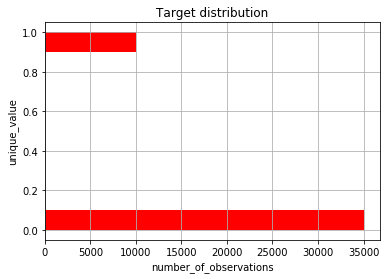

In [37]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [38]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [39]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [99]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [41]:
#!pip install watermark
%load_ext watermark

In [42]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

CPython 3.5.3
IPython 6.2.1

numpy 1.13.3
scipy 0.19.1
pandas 0.20.3
matplotlib 2.1.0
sklearn 0.19.0

compiler   : GCC 6.3.0 20170406
system     : Linux
release    : 4.10.0-33-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 658f5e829e259229a707199ad0146d7621e53f42


# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
- 655 ответ

In [43]:
table['SeriousDlqin2yrs'].values

array([0, 0, 0, ..., 1, 0, 1])

In [44]:
table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'].values

array([  400.,  4076.,  7166., ...,  3000.,  3000.,  9120.])

In [45]:
np.mean(table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'])

6392.1654251220143

In [46]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
bads = table[table['SeriousDlqin2yrs']==1]['MonthlyIncome'].values
goods = table[table['SeriousDlqin2yrs']==0]['MonthlyIncome'].values

# ставим seed для воспроизводимости результатов
np.random.seed(17)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
bads_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bads, 600)]
goods_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(goods, 600)]

#  выводим интервальную оценку среднего
print("Bads:  mean interval",  stat_intervals(bads_mean_scores, 0.1))
print("Goods:  mean interval",  stat_intervals(goods_mean_scores, 0.1))

Bads:  mean interval [ 5464.86218831  5637.27757331]
Goods:  mean interval [ 6295.53827525  6507.88098439]


In [47]:
stat_intervals(goods_mean_scores, 0.1)[0] - stat_intervals(bads_mean_scores, 0.1)[1]

658.26070194248132

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [49]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [50]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [51]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>**
- 0.82, нет
- 0.84, нет
- 0.82, да ответ
- 0.84, да

In [52]:
gcv = GridSearchCV(dt, tree_params, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [53]:
gcv.best_score_, gcv.best_params_

(0.82030234762096355, {'max_depth': 7, 'max_features': 6})

In [54]:
aucs = [x[1] for x in gcv.grid_scores_]

/home/vmt/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [55]:
gcv.grid_scores_

/home/vmt/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81089, std: 0.00332, params: {'max_depth': 5, 'max_features': 4},
 mean: 0.80439, std: 0.00196, params: {'max_depth': 5, 'max_features': 5},
 mean: 0.81112, std: 0.00241, params: {'max_depth': 5, 'max_features': 6},
 mean: 0.81487, std: 0.00196, params: {'max_depth': 5, 'max_features': 7},
 mean: 0.81574, std: 0.00277, params: {'max_depth': 6, 'max_features': 4},
 mean: 0.81615, std: 0.00296, params: {'max_depth': 6, 'max_features': 5},
 mean: 0.81464, std: 0.00298, params: {'max_depth': 6, 'max_features': 6},
 mean: 0.81904, std: 0.00119, params: {'max_depth': 6, 'max_features': 7},
 mean: 0.81755, std: 0.00272, params: {'max_depth': 7, 'max_features': 4},
 mean: 0.81686, std: 0.00444, params: {'max_depth': 7, 'max_features': 5},
 mean: 0.82030, std: 0.00276, params: {'max_depth': 7, 'max_features': 6},
 mean: 0.81903, std: 0.00201, params: {'max_depth': 7, 'max_features': 7},
 mean: 0.81449, std: 0.00128, params: {'max_depth': 8, 'max_features': 4},
 mean: 0.81661, std: 0.00

In [56]:
0.00276*100

0.27599999999999997

# Простая реализация случайного леса

**<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823 ответ
- 0.833
- 0.843
- 0.853

In [57]:
a = []
a.append(4)
a
X.shape[1]

7

In [58]:
#.loc[indicesX, X.columns[[0,2]]]
#[indicesX]

In [121]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
        self.test_inds = []
        self.train_inds = []
        
    def fit(self, X, y):
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            #select random features
            #deck = list(range(1, X.shape[1]))
            #np.random.shuffle(deck)
            #for i in range(self.max_features):
                #inds.append(deck.pop())
            
            inds = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(inds)
            #bootstrap sample
            #rows = np.random.choice(X[50:100].index.values, 10)
            #indicesX = np.random.randint(0, Xc.shape[0], Xc.shape[0])
            #indicesX = np.random.choice(Xc.index.values, Xc.shape[0], replace=True)
            indicesX = list(set(np.random.choice(range(X.shape[0]), X.shape[0], replace=True)))            
            
            currX = X[indicesX, :][:, inds]
            curry = y[indicesX]
            
            dt = DecisionTreeClassifier(random_state=self.random_state, max_features=self.max_features, max_depth=self.max_depth, class_weight='balanced')
            dt.fit(currX, curry)
            self.trees.append(dt)
            
            #self.test_inds.append(~X.index.isin(indicesX))
            #self.train_inds.append(indicesX)

            
        return self
        
    
    def predict_proba(self, X):
        predictions = []
        for i in range(self.n_estimators):
            X_feat = X[:,self.feat_ids_by_tree[i]]
            predictions.append(self.trees[i].predict_proba(X_feat))  
        return np.mean(predictions, axis=0)

In [122]:
rfc = RandomForestClassifierCustom(n_estimators=10, max_depth=7, max_features=6, random_state=17)


In [123]:
cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc')

TypeError: unhashable type: 'list'

In [68]:
np.mean(cross_val_score(rfc, X, y, cv=skf, scoring='roc_auc'))

0.81740766284379407

In [376]:
X_test = X.loc[rfc.test_inds[2], X.columns[rfc.feat_ids_by_tree[2]]]

**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.823
- 0.833 ответ
- 0.843
- 0.853

In [580]:
from sklearn.ensemble import RandomForestClassifier
rfc_sk = RandomForestClassifier(n_estimators=10, max_depth=7, max_features=6, random_state=17)
np.mean(cross_val_score(rfc_sk, X, y, cv=skf, scoring='roc_auc'))

0.830519720262196

# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
- `max_depth=8, max_features=4` ответ
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [581]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [582]:
rfc_sk2 = RandomForestClassifier(n_estimators=10, random_state=17)

In [583]:
gcv_rf = GridSearchCV(rfc_sk2, forest_params, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_rf.fit(X, y)

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   59.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': range(4, 8), 'max_depth': range(5, 16)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [584]:
gcv_rf.best_score_, gcv_rf.best_params_

(0.83286806314143702, {'max_depth': 8, 'max_features': 4})

# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778 ответ
- 0.788
- 0.798
- 0.808

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [11]:
gcv_l = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_l.fit(X, y)

NameError: name 'X' is not defined

In [587]:
gcv_l.best_score_, gcv_l.best_params_

(0.78786267573072055, {'logit__C': 100000.0})

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://yadi.sk/d/pHZlDkg-3NSUQW).

In [3]:
# Загрузим данные
df = pd.read_csv("../../data/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [4]:
np.logspace(-8, 8, 17)
np.array([0.1, 1, 10, 100])

array([   0.1,    1. ,   10. ,  100. ])

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

In [13]:
logit_pipe_params2 = {'clf__C': np.array([0.1, 1, 10, 100])}

dict_keys(['vectorizer__input', 'steps', 'vectorizer__stop_words', 'vectorizer__lowercase', 'vectorizer', 'clf__C', 'clf__n_jobs', 'vectorizer__max_df', 'vectorizer__dtype', 'vectorizer__max_features', 'clf__intercept_scaling', 'clf', 'vectorizer__binary', 'vectorizer__token_pattern', 'vectorizer__strip_accents', 'vectorizer__min_df', 'clf__tol', 'memory', 'clf__solver', 'vectorizer__preprocessor', 'clf__fit_intercept', 'clf__random_state', 'vectorizer__ngram_range', 'vectorizer__encoding', 'vectorizer__decode_error', 'vectorizer__tokenizer', 'vectorizer__analyzer', 'vectorizer__vocabulary', 'clf__class_weight', 'clf__warm_start', 'clf__verbose', 'clf__penalty', 'clf__max_iter', 'clf__multi_class', 'clf__dual'])

In [15]:
gcv_l2 = GridSearchCV(classifier, logit_pipe_params2, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_l2.fit(X_text, y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__C': array([   0.1,    1. ,   10. ,  100. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85 ответ

In [16]:
gcv_l2.best_score_, gcv_l2.best_params_

(0.85869298711881148, {'clf__C': 1.0})

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [17]:
from sklearn.ensemble import RandomForestClassifier
#rfc_sk = RandomForestClassifier(n_estimators=10, max_depth=7, max_features=6, random_state=17)
#np.mean(cross_val_score(rfc_sk, X, y, cv=skf, scoring='roc_auc'))

In [28]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

forest_params = {'clf__max_depth': max_depth,
                 'clf__max_features': max_features,
                 'clf__min_samples_leaf': min_samples_leaf}

In [29]:
classifier.get_params().keys()

dict_keys(['vectorizer__input', 'clf__min_samples_split', 'clf__n_jobs', 'memory', 'vectorizer__token_pattern', 'vectorizer__max_features', 'vectorizer__ngram_range', 'vectorizer__lowercase', 'vectorizer__tokenizer', 'clf', 'vectorizer__preprocessor', 'vectorizer', 'clf__class_weight', 'steps', 'clf__max_features', 'vectorizer__analyzer', 'vectorizer__binary', 'clf__min_weight_fraction_leaf', 'vectorizer__strip_accents', 'clf__max_depth', 'clf__bootstrap', 'vectorizer__dtype', 'vectorizer__max_df', 'clf__min_impurity_decrease', 'clf__verbose', 'vectorizer__vocabulary', 'vectorizer__decode_error', 'vectorizer__min_df', 'vectorizer__stop_words', 'clf__warm_start', 'clf__random_state', 'clf__criterion', 'clf__n_estimators', 'clf__max_leaf_nodes', 'vectorizer__encoding', 'clf__oob_score', 'clf__min_impurity_split', 'clf__min_samples_leaf'])

In [30]:
gcv_l3 = GridSearchCV(classifier, forest_params, n_jobs=-1, cv=skf, verbose=1, scoring='roc_auc')
gcv_l3.fit(X_text, y_text)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 47.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__max_features': [0.3, 0.5, 0.7], 'clf__max_depth': [None], 'clf__min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [31]:
gcv_l3.best_score_, gcv_l3.best_params_

(0.74727464315145131,
 {'clf__max_depth': None,
  'clf__max_features': 0.5,
  'clf__min_samples_leaf': 1})